# Load and display downloaded point cloud

In [ ]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import matplotlib.pyplot as plt
import numpy as np
from os import path
import os

In [ ]:
root_path = os.getenv('WIN_GITHUB')

In [ ]:
%pwd

'/mnt/c/Users/GGPC/Documents/GitHub/wind-simulation/nbs'

In [ ]:
print(root_path)

/mnt/c/Users/GGPC/Documents/GitHub/


In [ ]:
c_path_north = os.path.join(*[root_path,'wind-simulation/data/raw/','lds-auckland-north-lidar-1m-dem-2016-2018-GTiff'])
c_path_south = os.path.join(*[root_path,'wind-simulation/data/raw/','lds-auckland-south-lidar-1m-dsm-2016-2017-GTiff'])
#ds-auckland-south-lidar-1m-dsm-2016-2017-GTiff

In [ ]:
print(c_path_north)

/mnt/c/Users/GGPC/Documents/GitHub/wind-simulation/data/raw/lds-auckland-north-lidar-1m-dem-2016-2018-GTiff


In [ ]:
raster_files = glob.glob(f"{c_path_north}/*.tif") + glob.glob(f"{c_path_south}/*.tif")

In [ ]:
rasters = []

In [ ]:
# Open the rasters
for file in raster_files:
    src = rasterio.open(file)
    rasters.append(src)

In [ ]:
# Merge rasters
mosaic, out_trans = merge(rasters)

In [ ]:
mosaic[0,20,20]

-9999.0

/tmp/ipykernel_617/1990142664.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("BrBG").copy()
  cmap.set_bad(color='white')


<matplotlib.image.AxesImage>

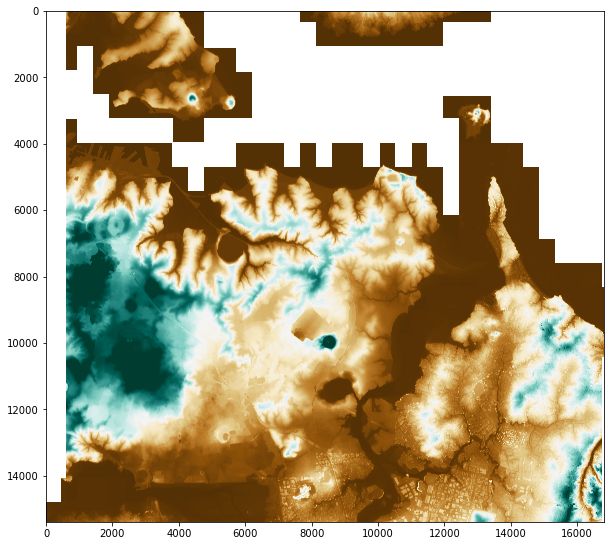

In [ ]:
 #Set the no-data value (replace with the actual no-data value for your data)
no_data_value = -9999

# Mask the no-data values
mosaic_masked = np.ma.masked_where(mosaic[0] == no_data_value, mosaic[0])

# Choose a colormap
cmap = plt.cm.BrBG
# Set the 'bad' data (masked data) color to 'white' or any other color
cmap.set_bad(color='white')

# Plot the masked array with the colormap
plt.figure(figsize=(10, 10))
plt.imshow(mosaic_masked, cmap=cmap)

# Optionally, set the color range to the 2nd and 98th percentiles to enhance contrast
vmin, vmax = np.percentile(mosaic_masked.compressed(), (2, 98))
plt.imshow(mosaic_masked, cmap=cmap, vmin=vmin, vmax=vmax)

In [ ]:
max_height = mosaic_masked.data.max()

In [ ]:
data_surface = mosaic_masked.data[0:8000,6000:-1]

In [ ]:
data_surface[data_surface <0 ] = 0

<matplotlib.image.AxesImage>

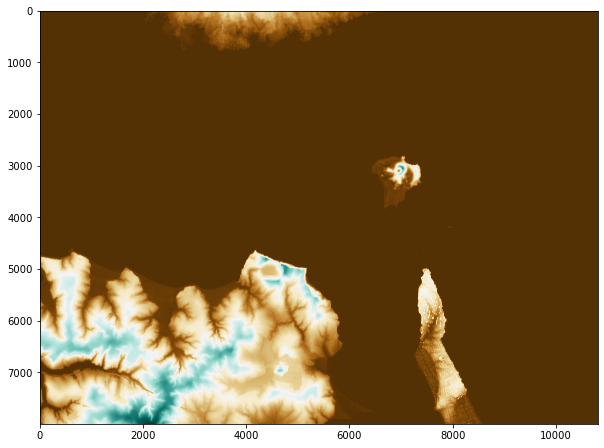

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(data_surface,cmap=cmap)

In [ ]:
delta_x, delta_y = 10, 10

In [ ]:
stride = 5

In [ ]:
# Pad the 'data_surface' array to the right with 2000 columns of zeros
extended_data_surface = np.pad(data_surface, ((0, 0), (0, 2000)), 'constant', constant_values=0)[::stride,::stride]
print(extended_data_surface)

[[ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 ...
 [12.69 12.1  10.35 ...  0.    0.    0.  ]
 [14.55 13.27 11.39 ...  0.    0.    0.  ]
 [15.14 14.6  13.99 ...  0.    0.    0.  ]]


<matplotlib.image.AxesImage>

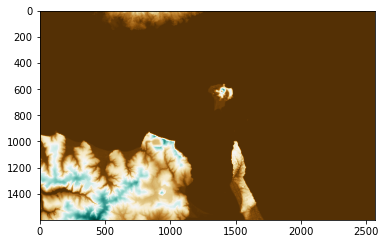

In [ ]:
plt.imshow(extended_data_surface,cmap=cmap)

In [ ]:
matrix_size = (extended_data_surface.shape[0]*extended_data_surface.shape[1]*200/1e6)*8

In [ ]:
print(f'Matrix Size {matrix_size} MB')

Matrix Size 6558.72 MB


In [ ]:
z_max = int(np.round(max_height,-2)); print(z_max)

200


In [ ]:
def height_matrix_to_voxel_matrix(height_matrix, headroom, stride):
    # Get the dimensions of the 2D height matrix
    
    strided_matrix = height_matrix[::stride,::stride]
    rows, cols = strided_matrix.shape
    
    # Determine the maximum height to set the depth of the 3D voxel matrix
    max_height = int(np.max(height_matrix)) + int(headroom)
    print(max_height)
    
    # Create a 3D voxel matrix initialized to 0 (no voxel)
    # The shape is (height, rows, cols) to represent (z, y, x) coordinates
    voxel_matrix = np.zeros((max_height, rows, cols), dtype=np.int8)
    
    # Fill the voxel matrix based on the heights specified in the height_matrix
    for x in range(rows):
        for y in range(cols):
            height = int(strided_matrix[x, y]/stride)
            voxel_matrix[:height, x, y] = 1  # Fill column with voxels up to the specified height
    return voxel_matrix

In [ ]:
voxel_matrix = height_matrix_to_voxel_matrix(extended_data_surface,0,stride)

79


<matplotlib.image.AxesImage>

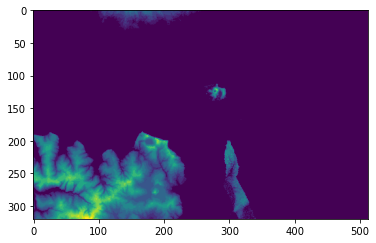

In [ ]:
plt.imshow(np.sum(voxel_matrix,0))

In [ ]:
from vedo import *
settings.default_backend='vtk'

In [ ]:
voxel_matrix_ = voxel_matrix.astype(np.uint8)

In [ ]:
 volume = Volume(voxel_matrix_)

In [ ]:
 plotter = Plotter()

In [ ]:
plotter.add(volume)

<vedo.plotter.Plotter>

In [ ]:
show(volume)

<vedo.plotter.Plotter>

# Determine boundary conditions

*Boundary Labels:* Denote the boundaries of the box as: N,S,E,W,T,B for North, South, East, West, Top, Bottom respectively.

*Direcitons:* We intend for wind to be blowing horizontally but at a particular compass bearing. This means there are 8 cases for the boundary conditions:

z is the first dimension of the voxel space
y is the second dimension with the 0th position being north
x is the third dimension, 0th position being to the west

Cases 0 to 3: With wind at 0, 90, 180, 270 degrees we expect that one boudary in either the xz or yz plane will have either + or - velocity.

Cases 4 to 7: 

NE quadrent - (+vy, -vx)
SE quadrent - (-vy, -vx)
SW quadrent - (-vy, +vx)
NW quadrent - (+vy, +vx)

*Box cross section boundaries*

Each of the four quandrents are bounded by land. So looking at any of the box sides one expects to see portions of land and portions of clear air. 

Question:
1. Can we simply make all of the land voxels non slip conditions?

The where the wind is incident the boarders will be constant velocity boundaries, and Do Not Care for the ceiling and the remaining boarders where the voxels are not land.